In [4]:
import sys
sys.path.append("../src/")
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch 
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [5]:
csv_path = '../src/outputs/run_history_emb.csv'
# csv_path = '/home/azureuser/cloudfiles/code/outputs/run_history.csv'

df = pd.read_csv('../src/outputs/run_history.csv', sep=';', index_col=0)
df_emb = pd.read_csv('../src/outputs/run_history_emb_idx.csv', sep=';', index_col=0)
np_emb_state = np.load('../src/outputs/emb_states.npy', allow_pickle=True)
np_emb_next_state = np.load('../src/outputs/next_state_emb.npy', allow_pickle=True)

In [6]:
df.head()

,episode,step,original_payload,state,action,next_state,reward,win
0,1,1,select * from users where id = '1'<@.. or 1 =...,select * from users where id = '1'<@.. or 1 =...,22,select * from users where id = '1'<@.. or 1 =...,-0.537037,0
1,1,2,select * from users where id = '1'<@.. or 1 =...,select * from users where id = '1'<@.. or 1 =...,19,select * from users where id = '1'<@.. or 1 =...,-0.637037,0
2,1,3,select * from users where id = '1'<@.. or 1 =...,select * from users where id = '1'<@.. or 1 =...,15,select * from users where id = '1'<@.. or 1 =...,-0.737037,0
3,1,4,select * from users where id = '1'<@.. or 1 =...,select * from users where id = '1'<@.. or 1 =...,8,select * from users where id = '1'<@.. or (SE...,-0.869444,0
4,1,5,select * from users where id = '1'<@.. or 1 =...,select * from users where id = '1'<@.. or (SE...,0,/**/select/**/*/**/from/**/users/**/where/**/i...,-0.825000,0


In [7]:
df.shape

(24908, 8)

In [8]:
np_emb_state.shape

(24908,)

In [54]:
np_emb_state_2 = np.array([np.float32(x) for x in np_emb_state])
sqli_labels = [x.replace('\n', '') for x in df['state']]

In [10]:
np_emb_state[0].shape

(768,)

In [11]:
np.savetxt('metadata.txt', sqli_labels, delimiter='\t', fmt='%s')
np.savetxt('features.txt', np_emb_state_2, delimiter='\t')

In [ ]:
# We want to get TSNE embedding with 2 dimensions
n_components = 2
tsne = TSNE(n_components)
tsne_result = tsne.fit_transform(np_emb_state_2)
tsne_result.shape

In [ ]:
# Plot the result of our TSNE with the label color coded
# A lot of the stuff here is about making the plot look pretty and not TSNE
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1]})
fig, ax = plt.subplots(1, figsize=(15, 15))

sns.scatterplot(x='tsne_1', y='tsne_2', data=tsne_result_df, ax=ax,s=20)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)

ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

In [12]:
actions = [x for x in df['action']]
print(actions[0:10])
a_t = torch.Tensor(actions).to(torch.int64)
print(a_t)

[22, 19, 15, 8, 0, 7, 3, 23, 25, 18]
tensor([22, 19, 15,  ..., 16, 20,  9])


In [13]:
actions_one_hot = torch.nn.functional.one_hot(a_t)

In [14]:
# actions_one_hot = torch.stack(actions_one_hot)
actions_one_hot.size()

torch.Size([24908, 26])

In [15]:
np_emb_state.shape

(24908,)

In [16]:
from torch.utils.data import TensorDataset, DataLoader

stacked = np.stack(np_emb_state)
print(stacked.shape)

t_emb = torch.from_numpy(stacked)
print(t_emb.size())



(24908, 768)
torch.Size([24908, 768])


In [17]:
t_x = torch.cat([t_emb, actions_one_hot], dim=1)
print(t_x.size())


torch.Size([24908, 794])


In [18]:
t_x[0:2]

tensor([[ 0.1623, -0.1776,  0.0701,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1623, -0.1776,  0.0701,  ...,  0.0000,  0.0000,  0.0000]])

In [55]:
t_y = df['reward']
t_y = [np.float32(x) for x in t_y]
t_y = torch.Tensor(t_y).to(torch.float32)
print(t_y)

tensor([-0.5370, -0.6370, -0.7370,  ..., -2.8822, -2.9822, -3.0796])


In [56]:
class SQLiDataset(torch.utils.data.Dataset):

    def __init__(self, X, y, scale_data=True):
        if not torch.is_tensor(X) and not torch.is_tensor(y):
          # Apply scaling if necessary
            if scale_data:
                X = StandardScaler().fit_transform(X)
            self.X = torch.from_numpy(X)
            self.y = torch.from_numpy(y)
        if torch.is_tensor(X) and torch.is_tensor(y):
            if scale_data:
                self.X = torch.nn.functional.normalize(X)
                self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [57]:
df_dataset = SQLiDataset(t_x,t_y) # create your datset


In [58]:
df_dataset[0]

(tensor([ 1.2931e-02, -1.4143e-02,  5.5855e-03,  1.6344e-02,  1.6026e-03,
          1.2289e-02,  3.9901e-03, -5.7610e-03,  8.5404e-04, -4.1324e-03,
         -9.7086e-03, -6.5811e-03,  4.5324e-03, -9.9580e-03,  2.2600e-02,
         -1.9146e-03, -6.3548e-03, -5.2546e-03,  2.6897e-03,  3.6181e-02,
          3.4488e-03,  8.7928e-03,  1.1742e-02,  6.5928e-04, -1.8527e-03,
         -3.9596e-03,  1.0660e-02,  8.4048e-03, -5.1416e-03, -2.4669e-04,
         -3.5284e-03,  1.1193e-02,  9.1718e-04,  2.5720e-03,  9.0391e-03,
         -1.6371e-03,  1.5715e-02, -2.7340e-03, -9.6294e-03,  7.3590e-03,
         -1.6091e-02, -1.5547e-02, -1.0492e-03, -8.3873e-05,  6.8688e-03,
          9.1807e-04,  5.1240e-03,  2.2012e-02, -3.7152e-03, -3.5218e-03,
         -7.7241e-03,  1.4926e-02,  1.4062e-03,  2.3296e-03,  2.7629e-03,
         -2.9075e-04, -2.9533e-03, -9.2138e-03,  1.6725e-02,  1.0073e-03,
         -1.6200e-03,  4.1777e-02, -2.7387e-02,  2.2494e-03, -6.5844e-03,
          2.8995e-03, -6.4408e-03,  1.

In [59]:
train_set, val_set = torch.utils.data.random_split(df_dataset, [0.7, 0.3], generator=torch.Generator().manual_seed(42))

In [60]:
print(len(df_dataset))
print(len(train_set))
print(len(val_set))

24908
17436
7472


In [61]:
rewards = df['reward']

<AxesSubplot: >

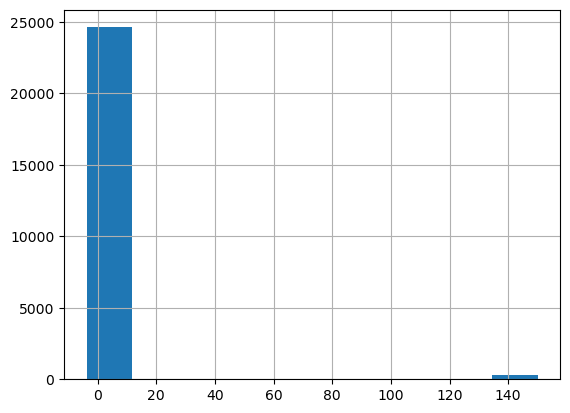

In [62]:
rewards.hist()

Claramente tenemos los episodios que ganan pronto y los que no ganan casi nunca...

<AxesSubplot: >

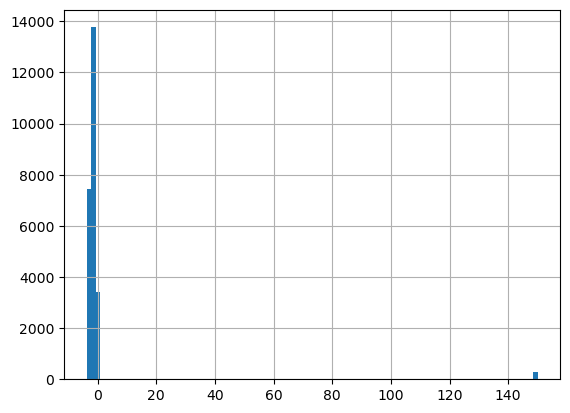

In [63]:
rewards.hist(bins=100)

<AxesSubplot: >

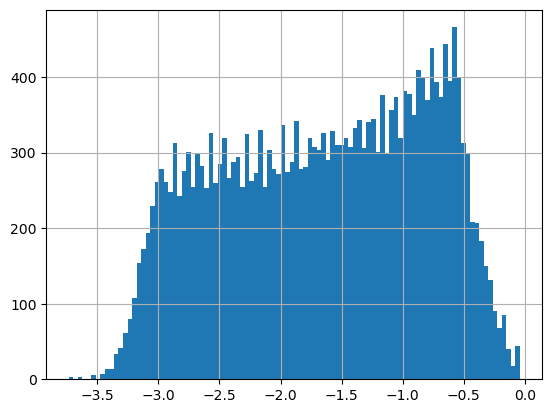

In [64]:
df[df['reward'] <= 100]['reward'].hist(bins=100)

Veamos si puedo ver en el espacio latente qué embeddings tienden a tener un reward mas alto

In [65]:
sqli_labels = ["0" if float(x) < 100 else "1" for x in df['reward']]

In [66]:
sqli_labels[0:10]

['0', '0', '0', '0', '0', '0', '0', '0', '0', '0']

In [ ]:
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1]})
fig, ax = plt.subplots(1, figsize=(15, 15))

sns.scatterplot(x='tsne_1', y='tsne_2', hue=sqli_labels, data=tsne_result_df, ax=ax,s=20)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)

ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

In [67]:
class SimpleNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.hid1 = torch.nn.Linear(794, 128)  
        self.hid2 = torch.nn.Linear(128, 32)
        self.oupt = torch.nn.Linear(32, 1)

        torch.nn.init.xavier_uniform_(self.hid1.weight)
        torch.nn.init.zeros_(self.hid1.bias)
        torch.nn.init.xavier_uniform_(self.hid2.weight)
        torch.nn.init.zeros_(self.hid2.bias)
        torch.nn.init.xavier_uniform_(self.oupt.weight)
        torch.nn.init.zeros_(self.oupt.bias)

    def forward(self, x):
        z = torch.relu(self.hid1(x))
        z = torch.relu(self.hid2(z))
        z = self.oupt(z)  # no activation
        return z

In [88]:
from tqdm.notebook import tqdm
# Initialize the MLP
mlp = SimpleNet()

lr = 1e-4
n_epochs = 100
batch_size = 10

trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)

# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []

# Define the loss function and optimizer
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=lr)
  
# Run the training loop
for epoch in range(n_epochs): 
    mlp.train()
    print('Starting epoch %d' %epoch)
    
    # Set current loss value
    current_loss = 0.0
    epoch_losses = []
    
    # Iterate over the DataLoader for training data
    for i, data in enumerate(trainloader, 0):
      
        
      # Get and prepare inputs
        inputs, targets = data
        # inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))
      
      # Zero the gradients
        optimizer.zero_grad()
      
      # Perform forward pass
        outputs = mlp(inputs)
      
      # Compute loss
        loss = loss_function(outputs, targets)
      
      # Perform backward pass
        loss.backward()
      
      # Perform optimization
        optimizer.step()
      
      # Print statistics
        current_loss += loss.item()
        if i % 100 == 0:
            current_loss = current_loss/(100*batch_size)
            epoch_losses.append(current_loss)
            print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss))
            current_loss = 0.0
                  
    e_l_m =  np.mean(epoch_losses)
    print('Avg. loss for epoch %d %.3f' %(epoch, e_l_m))
    history.append(e_l_m)
    print('Avg. loss for all epochs at epoch %d %.3f' %(epoch, np.mean(history)))

# Process is complete.
print('Training process has finished.')

Starting epoch 0
Loss after mini-batch     1: 0.004
Loss after mini-batch   101: 31.829
Loss after mini-batch   201: 27.317
Loss after mini-batch   301: 20.564
Loss after mini-batch   401: 29.545
Loss after mini-batch   501: 40.770
Loss after mini-batch   601: 13.773
Loss after mini-batch   701: 29.503
Loss after mini-batch   801: 22.771
Loss after mini-batch   901: 27.182
Loss after mini-batch  1001: 24.961
Loss after mini-batch  1101: 27.214
Loss after mini-batch  1201: 29.449
Loss after mini-batch  1301: 13.710
Loss after mini-batch  1401: 27.138
Loss after mini-batch  1501: 36.081
Loss after mini-batch  1601: 6.940
Loss after mini-batch  1701: 24.905
Avg. loss for epoch 0 24.092
Avg. loss for all epochs at epoch 0 24.092
Starting epoch 1
Loss after mini-batch     1: 0.003
Loss after mini-batch   101: 31.550
Loss after mini-batch   201: 27.072
Loss after mini-batch   301: 24.784
Loss after mini-batch   401: 40.359
Loss after mini-batch   501: 22.501
Loss after mini-batch   601: 31.4

Loss after mini-batch   301: 18.693
Loss after mini-batch   401: 25.230
Loss after mini-batch   501: 21.643
Loss after mini-batch   601: 20.107
Loss after mini-batch   701: 23.318
Loss after mini-batch   801: 27.535
Loss after mini-batch   901: 24.352
Loss after mini-batch  1001: 23.622
Loss after mini-batch  1101: 23.702
Loss after mini-batch  1201: 26.617
Loss after mini-batch  1301: 23.847
Loss after mini-batch  1401: 23.074
Loss after mini-batch  1501: 11.885
Loss after mini-batch  1601: 24.891
Loss after mini-batch  1701: 22.116
Avg. loss for epoch 11 21.336
Avg. loss for all epochs at epoch 11 22.697
Starting epoch 12
Loss after mini-batch     1: 0.027
Loss after mini-batch   101: 25.994
Loss after mini-batch   201: 17.484
Loss after mini-batch   301: 35.959
Loss after mini-batch   401: 20.409
Loss after mini-batch   501: 32.662
Loss after mini-batch   601: 13.650
Loss after mini-batch   701: 26.362
Loss after mini-batch   801: 22.685
Loss after mini-batch   901: 16.778
Loss afte

Loss after mini-batch   501: 27.206
Loss after mini-batch   601: 17.345
Loss after mini-batch   701: 17.843
Loss after mini-batch   801: 20.163
Loss after mini-batch   901: 16.173
Loss after mini-batch  1001: 20.683
Loss after mini-batch  1101: 19.498
Loss after mini-batch  1201: 16.923
Loss after mini-batch  1301: 12.272
Loss after mini-batch  1401: 24.014
Loss after mini-batch  1501: 23.087
Loss after mini-batch  1601: 29.744
Loss after mini-batch  1701: 24.353
Avg. loss for epoch 22 19.023
Avg. loss for all epochs at epoch 22 21.286
Starting epoch 23
Loss after mini-batch     1: 1.269
Loss after mini-batch   101: 23.022
Loss after mini-batch   201: 15.308
Loss after mini-batch   301: 16.235
Loss after mini-batch   401: 20.149
Loss after mini-batch   501: 18.692
Loss after mini-batch   601: 22.205
Loss after mini-batch   701: 9.909
Loss after mini-batch   801: 19.946
Loss after mini-batch   901: 17.302
Loss after mini-batch  1001: 21.015
Loss after mini-batch  1101: 27.133
Loss after

Loss after mini-batch   901: 21.343
Loss after mini-batch  1001: 16.377
Loss after mini-batch  1101: 20.359
Loss after mini-batch  1201: 26.923
Loss after mini-batch  1301: 17.593
Loss after mini-batch  1401: 19.687
Loss after mini-batch  1501: 18.807
Loss after mini-batch  1601: 15.009
Loss after mini-batch  1701: 12.554
Avg. loss for epoch 33 18.064
Avg. loss for all epochs at epoch 33 20.430
Starting epoch 34
Loss after mini-batch     1: 0.290
Loss after mini-batch   101: 21.765
Loss after mini-batch   201: 14.002
Loss after mini-batch   301: 22.851
Loss after mini-batch   401: 17.625
Loss after mini-batch   501: 16.345
Loss after mini-batch   601: 17.867
Loss after mini-batch   701: 13.248
Loss after mini-batch   801: 35.084
Loss after mini-batch   901: 21.907
Loss after mini-batch  1001: 20.912
Loss after mini-batch  1101: 20.553
Loss after mini-batch  1201: 11.691
Loss after mini-batch  1301: 17.341
Loss after mini-batch  1401: 24.343
Loss after mini-batch  1501: 13.668
Loss afte

Loss after mini-batch  1101: 22.744
Loss after mini-batch  1201: 16.249
Loss after mini-batch  1301: 10.007
Loss after mini-batch  1401: 18.318
Loss after mini-batch  1501: 20.812
Loss after mini-batch  1601: 23.852
Loss after mini-batch  1701: 29.278
Avg. loss for epoch 44 17.755
Avg. loss for all epochs at epoch 44 19.840
Starting epoch 45
Loss after mini-batch     1: 0.040
Loss after mini-batch   101: 17.783
Loss after mini-batch   201: 20.822
Loss after mini-batch   301: 18.234
Loss after mini-batch   401: 18.144
Loss after mini-batch   501: 18.928
Loss after mini-batch   601: 12.984
Loss after mini-batch   701: 22.566
Loss after mini-batch   801: 11.148
Loss after mini-batch   901: 21.163
Loss after mini-batch  1001: 13.342
Loss after mini-batch  1101: 14.140
Loss after mini-batch  1201: 22.315
Loss after mini-batch  1301: 15.736
Loss after mini-batch  1401: 15.542
Loss after mini-batch  1501: 26.485
Loss after mini-batch  1601: 19.994
Loss after mini-batch  1701: 30.411
Avg. loss

Loss after mini-batch  1401: 24.388
Loss after mini-batch  1501: 19.697
Loss after mini-batch  1601: 18.910
Loss after mini-batch  1701: 23.209
Avg. loss for epoch 55 16.692
Avg. loss for all epochs at epoch 55 19.327
Starting epoch 56
Loss after mini-batch     1: 0.022
Loss after mini-batch   101: 19.222
Loss after mini-batch   201: 18.143
Loss after mini-batch   301: 14.755
Loss after mini-batch   401: 19.313
Loss after mini-batch   501: 13.631
Loss after mini-batch   601: 17.111
Loss after mini-batch   701: 23.658
Loss after mini-batch   801: 24.414
Loss after mini-batch   901: 31.735
Loss after mini-batch  1001: 13.058
Loss after mini-batch  1101: 23.508
Loss after mini-batch  1201: 19.986
Loss after mini-batch  1301: 12.315
Loss after mini-batch  1401: 18.692
Loss after mini-batch  1501: 16.773
Loss after mini-batch  1601: 9.862
Loss after mini-batch  1701: 13.068
Avg. loss for epoch 56 17.181
Avg. loss for all epochs at epoch 56 19.289
Starting epoch 57
Loss after mini-batch     

Loss after mini-batch   101: 18.765
Loss after mini-batch   201: 10.924
Loss after mini-batch   301: 21.522
Loss after mini-batch   401: 11.077
Loss after mini-batch   501: 12.452
Loss after mini-batch   601: 16.351
Loss after mini-batch   701: 19.149
Loss after mini-batch   801: 16.061
Loss after mini-batch   901: 7.333
Loss after mini-batch  1001: 25.345
Loss after mini-batch  1101: 22.478
Loss after mini-batch  1201: 18.328
Loss after mini-batch  1301: 18.678
Loss after mini-batch  1401: 13.901
Loss after mini-batch  1501: 17.977
Loss after mini-batch  1601: 19.763
Loss after mini-batch  1701: 23.167
Avg. loss for epoch 67 16.300
Avg. loss for all epochs at epoch 67 18.827
Starting epoch 68
Loss after mini-batch     1: 0.014
Loss after mini-batch   101: 12.847
Loss after mini-batch   201: 14.177
Loss after mini-batch   301: 17.632
Loss after mini-batch   401: 22.948
Loss after mini-batch   501: 16.361
Loss after mini-batch   601: 19.059
Loss after mini-batch   701: 18.519
Loss after

Loss after mini-batch   501: 19.195
Loss after mini-batch   601: 6.958
Loss after mini-batch   701: 23.030
Loss after mini-batch   801: 17.669
Loss after mini-batch   901: 11.742
Loss after mini-batch  1001: 14.734
Loss after mini-batch  1101: 11.906
Loss after mini-batch  1201: 10.191
Loss after mini-batch  1301: 12.210
Loss after mini-batch  1401: 15.504
Loss after mini-batch  1501: 16.411
Loss after mini-batch  1601: 19.814
Loss after mini-batch  1701: 20.891
Avg. loss for epoch 78 15.021
Avg. loss for all epochs at epoch 78 18.404
Starting epoch 79
Loss after mini-batch     1: 0.003
Loss after mini-batch   101: 7.190
Loss after mini-batch   201: 16.324
Loss after mini-batch   301: 14.416
Loss after mini-batch   401: 7.808
Loss after mini-batch   501: 14.425
Loss after mini-batch   601: 19.434
Loss after mini-batch   701: 16.446
Loss after mini-batch   801: 14.529
Loss after mini-batch   901: 24.110
Loss after mini-batch  1001: 20.701
Loss after mini-batch  1101: 14.285
Loss after m

Loss after mini-batch  1101: 15.247
Loss after mini-batch  1201: 13.867
Loss after mini-batch  1301: 16.232
Loss after mini-batch  1401: 16.366
Loss after mini-batch  1501: 20.950
Loss after mini-batch  1601: 16.735
Loss after mini-batch  1701: 15.504
Avg. loss for epoch 89 14.569
Avg. loss for all epochs at epoch 89 17.992
Starting epoch 90
Loss after mini-batch     1: 0.017
Loss after mini-batch   101: 13.011
Loss after mini-batch   201: 12.351
Loss after mini-batch   301: 15.929
Loss after mini-batch   401: 17.995
Loss after mini-batch   501: 17.338
Loss after mini-batch   601: 13.942
Loss after mini-batch   701: 21.172
Loss after mini-batch   801: 15.603
Loss after mini-batch   901: 8.543
Loss after mini-batch  1001: 11.584
Loss after mini-batch  1101: 15.032
Loss after mini-batch  1201: 14.065
Loss after mini-batch  1301: 14.695
Loss after mini-batch  1401: 18.688
Loss after mini-batch  1501: 12.604
Loss after mini-batch  1601: 18.130
Loss after mini-batch  1701: 20.982
Avg. loss 